In [79]:
from astropy.io import fits
from photutils.segmentation import SourceFinder, SourceCatalog, detect_sources
from astropy.visualization import *
import pyregion as pyr
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
from photutils.isophote import EllipseGeometry, Ellipse, build_ellipse_model
from photutils.aperture import EllipticalAperture

In [2]:
# Paths, lists & variables
path_data = '/home/aellien/JWST/data/'
path_scripts = '/home/aellien/JWST/JWST_scripts'
path_wavelets = '/home/aellien/JWST/wavelets/out15/'
path_plots = '/home/aellien/JWST/plots'
path_analysis = '/home/aellien/JWST/analysis/'

pix_scale = 0.063 # "/pix
physcale = 5.3 # kpc/"

f150w 1.3958706403978431 1.5820694494395617 2.593943216622969 0.3522905867181766


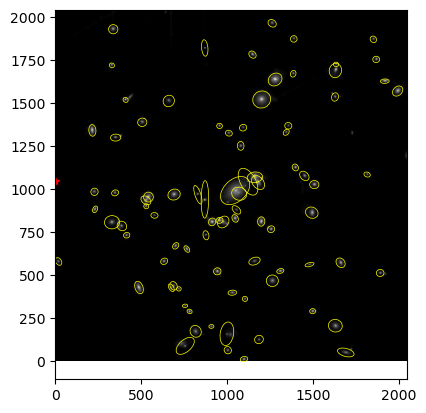

f277w 1.4152253383529096 1.4740275887386995 2.4036160391657377 0.2779045706799338


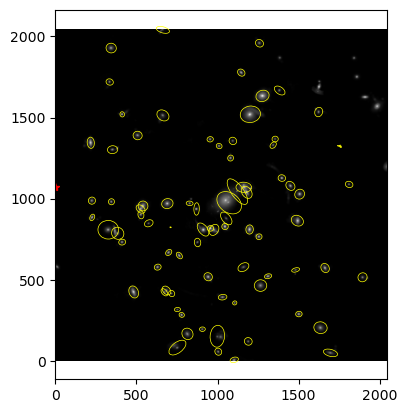

f090w 1.2140152747468258 1.334111451697967 2.3072331818712333 0.380528321343668


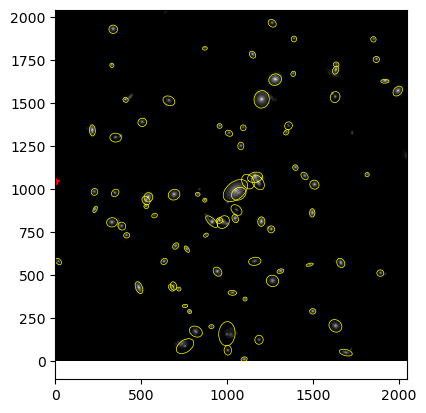

f200w 1.4351843621429334 1.6580587323992158 2.9150573139238296 0.31396981638446664


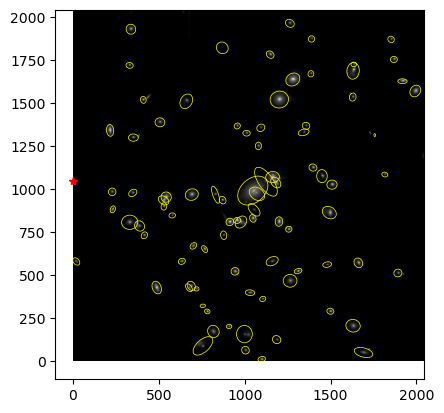

f444w 1.3104859382326173 1.3289237968295173 2.200399125436064 0.1931300840518695


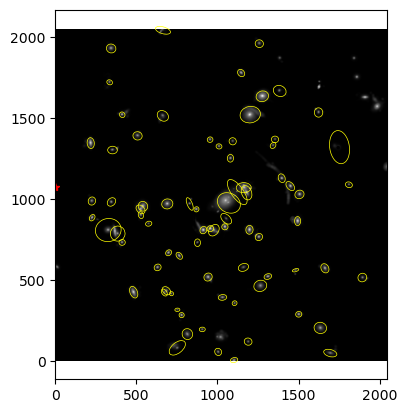

f356w 1.4729997592665385 1.4921890236198139 2.325013185769567 0.435452968935479


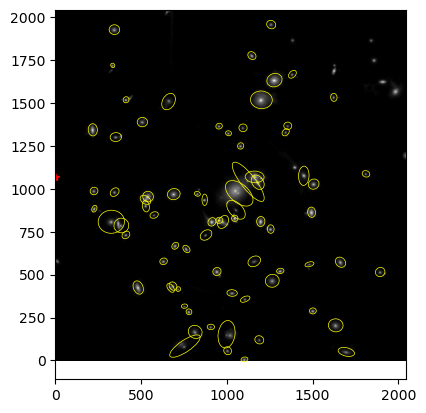

In [3]:
nfp = os.path.join(path_wavelets, '*gal.wav*fits')
for nf in glob.glob(nfp):
    filt = nf.split('_')[1]
    im = fits.getdata(nf)
    threshold = 1E-5 # ADU
    finder = SourceFinder(npixels=10, progress_bar=False)
    segment_map = finder(im, threshold)
    det_cat = SourceCatalog(im, segment_map)

    # Remove all leaking atoms from segmentation map & source catalog
    rgal = pyr.open(os.path.join(path_data, 'mahler_noirot_merged_member_gal_ra_dec_pix_long.reg'))
    only_gal = []
    
    for i, (x2, y2) in enumerate(det_cat.centroid):
        flag_rm = True
        lab = i+1
        for gal in rgal:
            x1, y1 = np.array(gal.coord_list)
            if np.sqrt( (x1 - x2)**2 + (y1 - y2)**2 ) < 10:
                #only_gal.append( det_cat.centroid, det_cat.kron_flux, det_cat.kron_fluxerr)
                flag_rm = False
                break
    
        if flag_rm == True:
            #print(lab)
            segment_map.remove_labels(lab)
            
    # clean source catalog
    det_cat = SourceCatalog(im, segment_map)
    tbl = det_cat.to_table()
    tbl.sort('kron_flux', reverse = True)

    bcg_ell = 1 - np.sqrt( 1 - tbl['eccentricity'][0]**2 )
    M12 = tbl['kron_flux'][0] / tbl['kron_flux'][1]
    M13 = tbl['kron_flux'][0] / tbl['kron_flux'][2]
    M14 = tbl['kron_flux'][0] / tbl['kron_flux'][3]
    print(filt, M12, M13, M14, bcg_ell )

    # plot
    plt.figure()
    plt.imshow(im, norm = ImageNormalize( im, interval = MinMaxInterval(), \
                                    stretch = LogStretch()), cmap = 'grey', origin = 'lower')
    det_cat.plot_kron_apertures(ax = plt.gca(), color = 'yellow', lw = 0.5)
    plt.plot(tbl['xcentroid'][0], 'r*')

    plt.show()

In [4]:
30 / physcale / pix_scale
50 / physcale / pix_scale


149.7454327643007

In [5]:
tbl

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
102,1072.1030754208557,973.9292169979888,None,1057,1146,905,990,2798.0,12.247681561940778,6.9143922632173425,-40.61546293809107,0.8254009024202934,1.0140713999835844e-05,4.024716134642432,0.0,392.529816732262,nan,3523.5112792456575,nan
179,1201.015886485283,1518.9614228316896,None,1122,1326,1436,1607,23836.0,18.174587665890627,14.702861892505334,-3.7105257221544363,0.5878373816831511,1.000427368553379e-05,27.723899068427315,0.0,2387.442963800224,nan,2392.065074742541,nan
181,1277.2531553230654,1633.7459353119868,None,1146,1357,1568,1719,21358.0,12.907733838636961,10.990774918471251,20.382696831058105,0.5243747881037982,1.0013830665964833e-05,28.60995357671173,0.0,2445.005994332604,nan,2361.303577142109,nan
111,1161.7842665717396,1069.8222466193138,None,1062,1220,1030,1136,5883.0,13.673620205438512,8.381553653143284,-2.0626350586741222,0.7901042147421002,1.0171946020628724e-05,9.16358425309476,0.0,1169.2679185049603,nan,1515.4801275156615,nan
119,1493.6759733957704,863.898590415301,None,1452,1552,774,933,10966.0,8.613696813699232,6.529705320771748,-82.48944314506589,0.6521839656291843,1.0001749644125278e-05,19.672979628812968,0.0,1145.6673403869568,nan,1121.2068359214486,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1481.3070065731802,560.582884243446,None,1438,1526,524,592,4349.0,7.688068855015211,3.826966826067928,15.822615906400769,0.8673033397092347,1.0000246036141378e-05,0.9511583896628568,0.0,46.25320402728361,nan,44.97954959939792,nan
8,1810.6967559370312,1087.5305245216248,None,1771,1853,1047,1122,5232.0,6.467307007313399,5.210961486576841,-19.89414698720337,0.5922707678342891,1.0030798458547923e-05,1.458309456935769,0.0,46.14215099204323,nan,44.42872678137571,nan


,ell_BCG_med,ell_BCG_err,ell_ICL_med,ell_ICL_err,PA_BCG_med,PA_BCG_err,PA_ICL_med,PA_ICL_err
f090w,0.543597,10.532508,0.638299,0.045970,39.247747,3790.659972,27.340522,9.282700
f150w,0.324492,18.266923,0.767560,0.086468,35.000000,12887.349259,24.703164,11.012913
f200w,0.468434,2.611653,0.658348,0.015374,35.747850,744.751018,27.295108,2.790582
f277w,0.477959,126.350388,0.637872,0.050558,41.264211,20558.486160,38.493234,8.723492
f356w,0.427278,38.725938,0.608231,0.025537,41.155542,8780.379986,38.270630,6.632846
f444w,0.498846,14.525295,0.632099,0.140400,41.743240,4332.852584,37.600241,15.255061


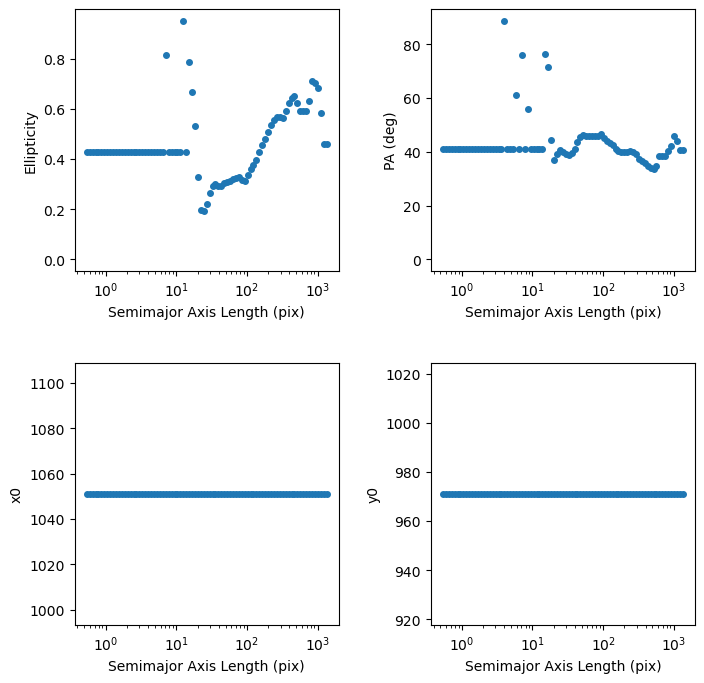

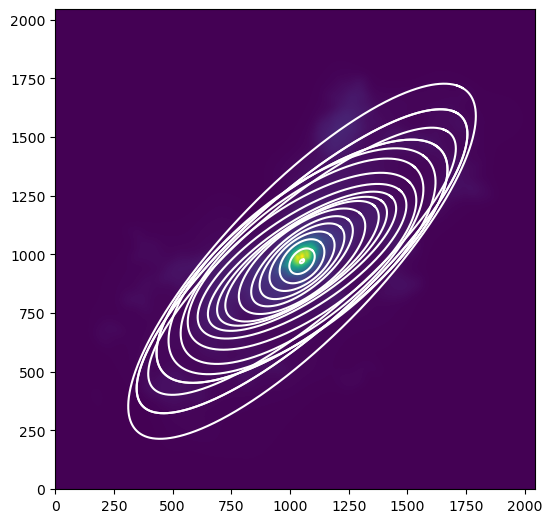

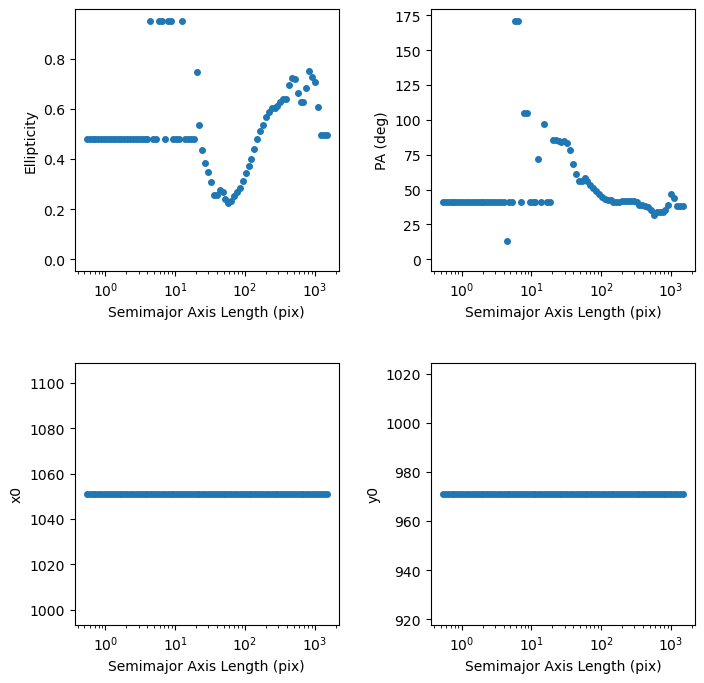

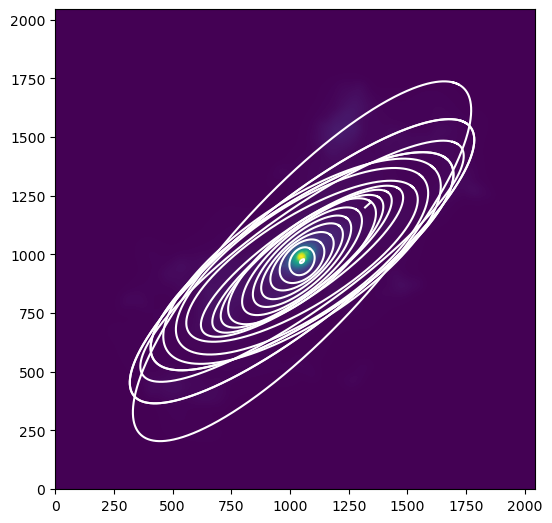

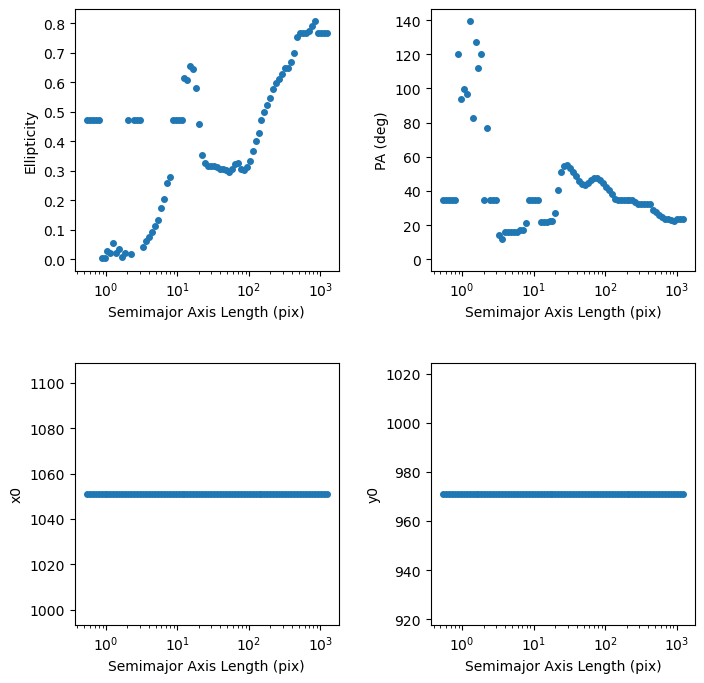

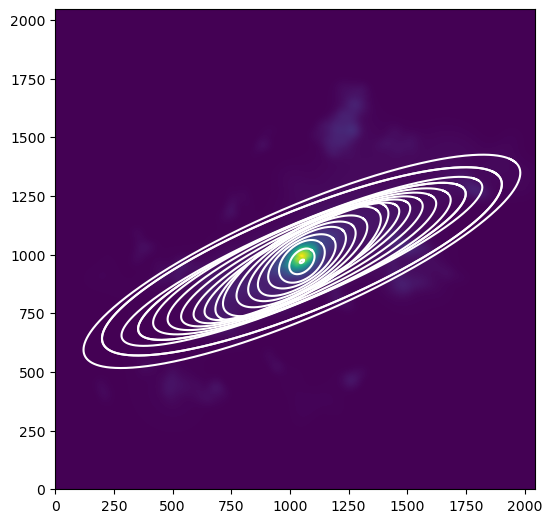

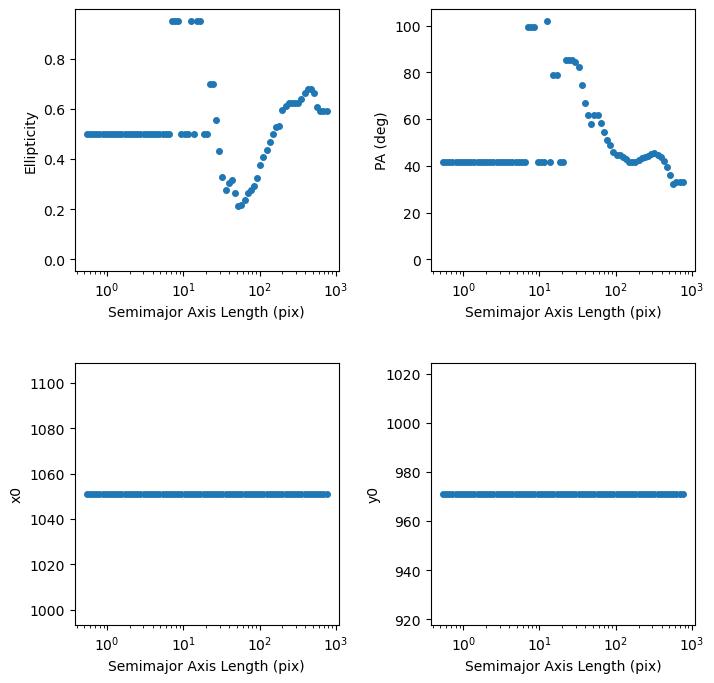

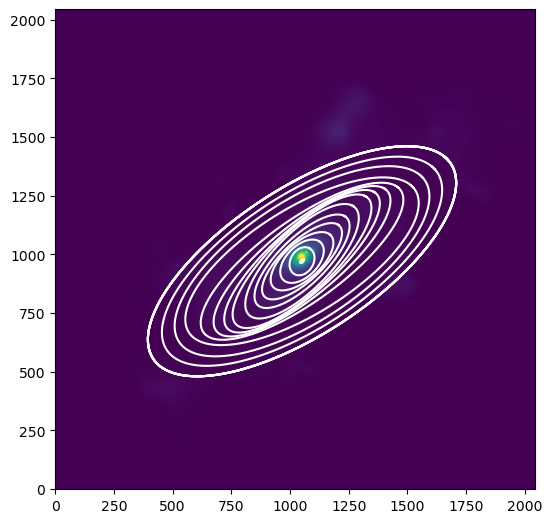

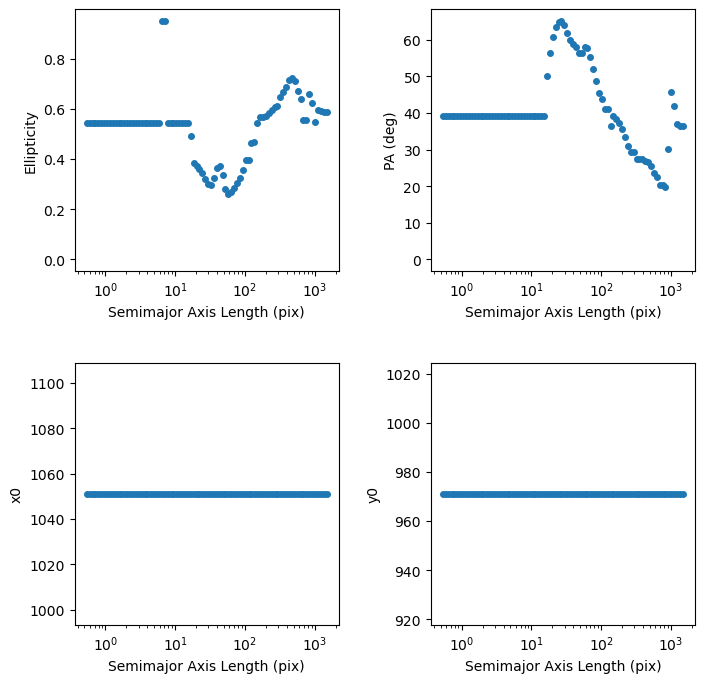

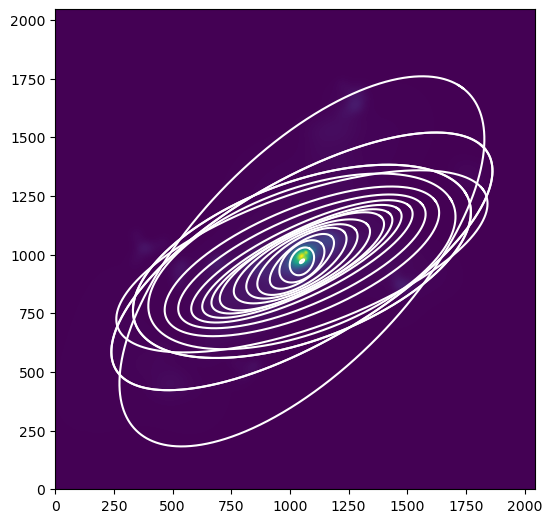

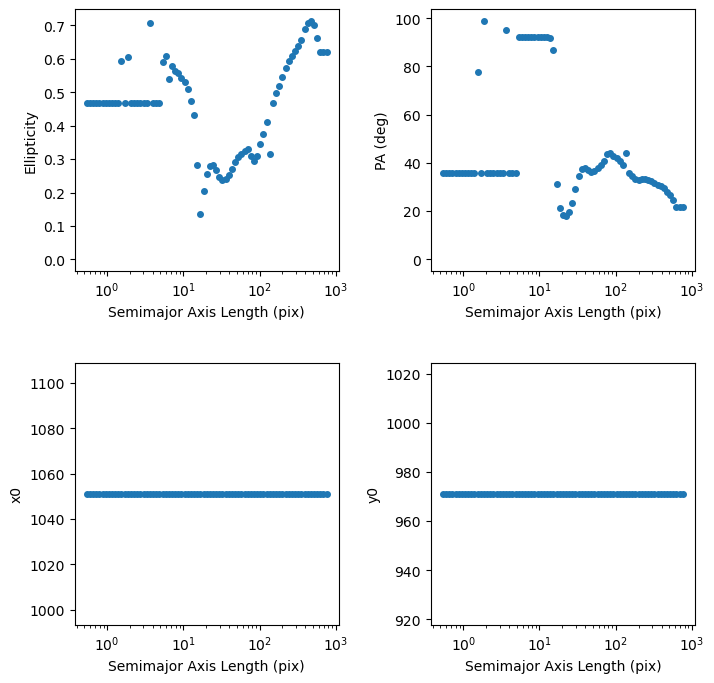

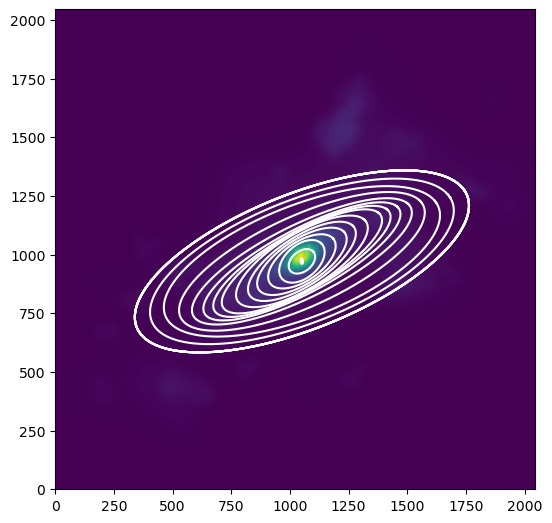

In [48]:
nfp = os.path.join(path_wavelets, '*icl.bcgwav*fits')
init = True
spix = 300 # pix, sep. radius ICL/BCG
for nf in glob.glob(nfp):
    filt = nf.split('_')[1]
    im = fits.getdata(nf)

    geometry = EllipseGeometry(y0 = 971, x0 = 1051, sma = 150, eps = 0.3, pa = 35 * np.pi / 180.0)
    aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                               geometry.sma * (1 - geometry.eps),
                               geometry.pa)
    ellipse = Ellipse(im, geometry)
    isolist = ellipse.fit_image(fix_center = True)
    #model_image = build_ellipse_model(im.shape, isolist)
    
    # xa, ya, ellipticity plot
    plt.figure(figsize=(8, 8))
    plt.subplots_adjust(hspace=0.35, wspace=0.35)
    
    plt.subplot(2, 2, 1)
    plt.errorbar(isolist.sma, isolist.eps, #yerr=isolist.ellip_err,
                 fmt='o', markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.xscale('log')
    #plt.yscale('log')
    plt.ylabel('Ellipticity')
    
    plt.subplot(2, 2, 2)
    plt.errorbar(isolist.sma, isolist.pa / np.pi * 180.0, #yerr=isolist.pa_err / np.pi * 80.0, 
                 fmt='o', markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.xscale('log')
    #plt.yscale('log')
    plt.ylabel('PA (deg)')
    
    plt.subplot(2, 2, 3)
    plt.errorbar(isolist.sma, isolist.x0, #yerr=isolist.x0_err, 
                 fmt='o',
                 markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.xscale('log')
    #plt.yscale('log')
    plt.ylabel('x0')
    
    plt.subplot(2, 2, 4)
    plt.errorbar(isolist.sma, isolist.y0, #yerr=isolist.y0_err, 
                 fmt='o',
                 markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.xscale('log')
    #plt.yscale('log')
    plt.ylabel('y0')    

    # plot ellipses
    fig, ax1 = plt.subplots(figsize=(14, 5), nrows=1, ncols=1)
    fig.subplots_adjust(left=0.04, right=0.98, bottom=0.02, top=0.98)
    ax1.imshow(im, origin='lower')    
    smas = np.linspace(10, 1000, 20)
    for sma in smas:
        iso = isolist.get_closest(sma)
        x, y, = iso.sampled_coordinates()
        ax1.plot(x, y, color='white')
    #plt.show()

    if init:

        df = pd.DataFrame( [[np.median(isolist.eps[isolist.sma < spix]), np.sqrt(np.sum(isolist.ellip_err[isolist.sma < spix]**2)),
                            np.median(isolist.eps[isolist.sma > spix]), np.sqrt(np.sum(isolist.ellip_err[isolist.sma > spix]**2)),
                            np.median(isolist.pa[isolist.sma < spix] / np.pi * 180.0), np.sqrt((np.sum(isolist.pa_err[isolist.sma < spix] / np.pi * 180.0)**2)),
                            np.median(isolist.pa[isolist.sma > spix] / np.pi * 180.0), np.sqrt((np.sum(isolist.pa_err[isolist.sma > spix] / np.pi * 180.0)**2)) ]],
                             columns = ['ell_BCG_med', 'ell_BCG_err', 
                                        'ell_ICL_med', 'ell_ICL_err', 
                                        'PA_BCG_med', 'PA_BCG_err', 
                                        'PA_ICL_med', 'PA_ICL_err'], index = [filt])
        init = False
    else:
        df = pd.concat( [df, pd.DataFrame( [[np.median(isolist.eps[isolist.sma < spix]), np.sqrt(np.sum(isolist.ellip_err[isolist.sma < spix]**2)),
                            np.median(isolist.eps[isolist.sma > spix]), np.sqrt(np.sum(isolist.ellip_err[isolist.sma > spix]**2)),
                            np.median(isolist.pa[isolist.sma < spix] / np.pi * 180.0), np.sqrt((np.sum(isolist.pa_err[isolist.sma < spix] / np.pi * 180.0)**2)),
                            np.median(isolist.pa[isolist.sma > spix] / np.pi * 180.0), np.sqrt((np.sum(isolist.pa_err[isolist.sma > spix] / np.pi * 180.0)**2)) ]],
                             columns = ['ell_BCG_med', 'ell_BCG_err', 
                                        'ell_ICL_med', 'ell_ICL_err', 
                                        'PA_BCG_med', 'PA_BCG_err', 
                                        'PA_ICL_med', 'PA_ICL_err'], index = [filt])])

df.sort_index()

In [89]:
nfp = os.path.join(path_wavelets, '*icl.bcgwav*fits')

for nf in glob.glob(nfp):
    
    filt = nf.split('_')[1]
    
    iclbcg = fits.getdata(nf) # icl + bcg
    icl = fits.getdata(nf[:-30]+"wavsizesepmask_005_080.fits") # icl
    bcg = iclbcg - icl # bcg

    threshold = 0 # ADU
    sm_icl = detect_sources(icl, threshold, npixels = 10)
    sm_bcg = detect_sources(bcg, threshold, npixels = 10)
    sm_iclbcg = detect_sources(iclbcg, threshold, npixels = 10)
    
    det_icl = SourceCatalog(icl, sm_icl).to_table()
    det_bcg = SourceCatalog(bcg, sm_bcg).to_table()
    det_iclbcg = SourceCatalog(iclbcg, sm_iclbcg).to_table()

    icl_ell = 1 - np.sqrt( 1 - det_icl['eccentricity'][0]**2 )
    bcg_ell = 1 - np.sqrt( 1 - det_bcg['eccentricity'][0]**2 )
    iclbcg_ell = 1 - np.sqrt( 1 - det_iclbcg['eccentricity'][0]**2 )

    print(icl_ell, bcg_ell, iclbcg_ell, icl_ell / bcg_ell)

0.5408742878570943 0.33889938381046236 0.5264148170365155 1.5959730636736458
0.5597636537561455 0.43694353149196097 0.5500431870817691 1.2810892333039245
0.5328517414645202 0.3597811738231169 0.5221507132287626 1.4810439796010333
0.5964140998779607 0.3972496112095887 0.571084885649731 1.5013585490038226
0.5027365536297089 0.26264121611363167 0.5023668470355657 1.9141571192398075
0.43318446231714336 0.3172836431124102 0.4175579880020688 1.3652908737046705


label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,1069.4256609849333,1055.2305154503067,None,0,2045,0,2045,3983670.0,424.416647367437,240.56595017912915,39.98715676503667,0.8238447343045254,1.5077286632095125e-26,0.40019953962372673,0.0,77807.75397698571,nan,77307.4189415099,nan
